In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Compare master with a single version of our algorithm

## Read data

In [2]:
df_master = pd.read_csv('20-06-2022/limit-threads/master.csv')
df_master['branch'] = 'master'

df_new = pd.read_csv('20-06-2022/limit-threads/new-algorithm-20-us.csv')
df_new['branch'] = 'new-algorithm-20-us'

df = pd.concat([df_master, df_new], ignore_index = True)
df.sample(10)

,name,machine_id,threads,cpu_time_us,wall_clock_time_us,package_energy,core_energy,branch
237,NBody sequential,dahu-14.grenoble.grid5000.fr,1,37667,37771,2648797,292979,master
518,QuickSort,dahu-14.grenoble.grid5000.fr,17,64846,8217,768125,61920,new-algorithm-20-us
299,Travelling Salesman Problem,dahu-14.grenoble.grid5000.fr,10,4650,1076,70557,8170,master
890,MergeSort,dahu-14.grenoble.grid5000.fr,43,126080,14115,1284299,120916,new-algorithm-20-us
979,Travelling Salesman Problem,dahu-14.grenoble.grid5000.fr,10,5371,1161,91552,7711,new-algorithm-20-us
463,Life - parallel iterators generation,dahu-14.grenoble.grid5000.fr,15,238062,16008,1087644,127923,master
402,Life - sequential generation,dahu-14.grenoble.grid5000.fr,1,72501,72662,4387013,520782,master
150,MergeSort,dahu-14.grenoble.grid5000.fr,43,96399,13346,1112180,105447,master
972,Life - sequential generation,dahu-14.grenoble.grid5000.fr,1,72865,72949,4000906,353568,new-algorithm-20-us
846,NBody parallel reduce,dahu-14.grenoble.grid5000.fr,26,266384,11058,1431759,85344,new-algorithm-20-us


## Remove outliers

In [3]:
q_low = df["cpu_time_us"].quantile(0.01)
q_hi  = df["cpu_time_us"].quantile(0.99)
df = df[(df["cpu_time_us"] < q_hi) & (df["cpu_time_us"] > q_low)]

q_low = df["wall_clock_time_us"].quantile(0.01)
q_hi  = df["wall_clock_time_us"].quantile(0.99)
df = df[(df["wall_clock_time_us"] < q_hi) & (df["wall_clock_time_us"] > q_low)]

q_low = df["package_energy"].quantile(0.01)
q_hi  = df["package_energy"].quantile(0.99)
df = df[(df["package_energy"] < q_hi) & (df["package_energy"] > q_low)]

q_low = df["core_energy"].quantile(0.01)
q_hi  = df["core_energy"].quantile(0.99)
df = df[(df["core_energy"] < q_hi) & (df["core_energy"] > q_low)]

## Extract mean ratio

In [4]:
def extract_means(input_df):
    means = {'name': [],
             'branch': [],
             'cpu_time_us': [],
             'wall_clock_time_us': [],
             'core_energy': [],
             'package_energy': []}

    for algorithm in set(input_df['name']):
        algorithm_df = input_df[input_df['name'] == algorithm]
        means['name'].append(algorithm)
        means['branch'].append(algorithm_df['branch'].values[0])
        means['cpu_time_us'].append(algorithm_df['cpu_time_us'].mean())
        means['wall_clock_time_us'].append(algorithm_df['wall_clock_time_us'].mean())
        means['core_energy'].append(algorithm_df['core_energy'].mean())
        means['package_energy'].append(algorithm_df['package_energy'].mean())
    
    return means


master_dict = extract_means(df_master)
new_algorithm_dict = extract_means(df_new)
means = {'name': [], 
         'cpu_time_ratio': [],
         'wall_clock_time_ratio': [],
         'core_energy_ratio': [],
         'package_energy_ratio': []}

for index, algorithm in enumerate(master_dict['name']):
    means['name'].append(algorithm)
    means['cpu_time_ratio'].append(master_dict['cpu_time_us'][index] / new_algorithm_dict['cpu_time_us'][index])
    means['wall_clock_time_ratio'].append(master_dict['wall_clock_time_us'][index] / new_algorithm_dict['wall_clock_time_us'][index])
    means['core_energy_ratio'].append(master_dict['core_energy'][index] / new_algorithm_dict['core_energy'][index])
    means['package_energy_ratio'].append(master_dict['package_energy'][index] / new_algorithm_dict['package_energy'][index])

df_to_plot = pd.DataFrame(data=means)
df_to_plot = df_to_plot.sort_values('cpu_time_ratio', ascending = False)
display(df_to_plot)


,name,cpu_time_ratio,wall_clock_time_ratio,core_energy_ratio,package_energy_ratio
9,NBody parallel iterator,1.756815,1.587319,1.511025,1.362430
0,NBody parallel reduce,1.697634,1.623291,1.610353,1.236354
1,FrogJump,1.147779,1.089654,0.982360,0.920086
3,Life - parallel iterators generation,1.110648,1.056146,1.007454,0.872678
6,Life - parallel bridge generation,1.103673,1.103803,1.080238,0.977693
7,NBody sequential,1.005750,1.005579,0.948850,0.951011
2,Life - sequential generation,0.981353,0.981200,1.004067,0.956963
8,QuickSort,0.961352,0.888395,0.846902,0.756545
4,Travelling Salesman Problem,0.904219,0.944508,0.878685,0.785432
5,MergeSort,0.763712,0.882029,0.848567,0.701473


## Wall clock time

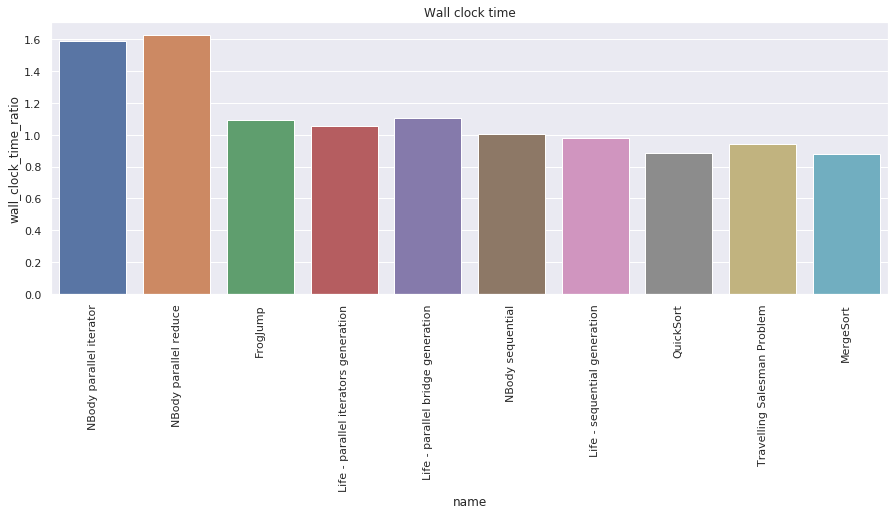

In [5]:
fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.set_title('Wall clock time')
ax1.set_ylabel('Time [us]')
ax1.set_xlabel('Algorithm')

sns.barplot(x='name', y='wall_clock_time_ratio', data=df_to_plot);
plt.xticks(rotation=90);

# x = mean(master) / mean(new_algorithm)
#     x < 1: we are losing
#     x > 1: we are winning

## CPU time

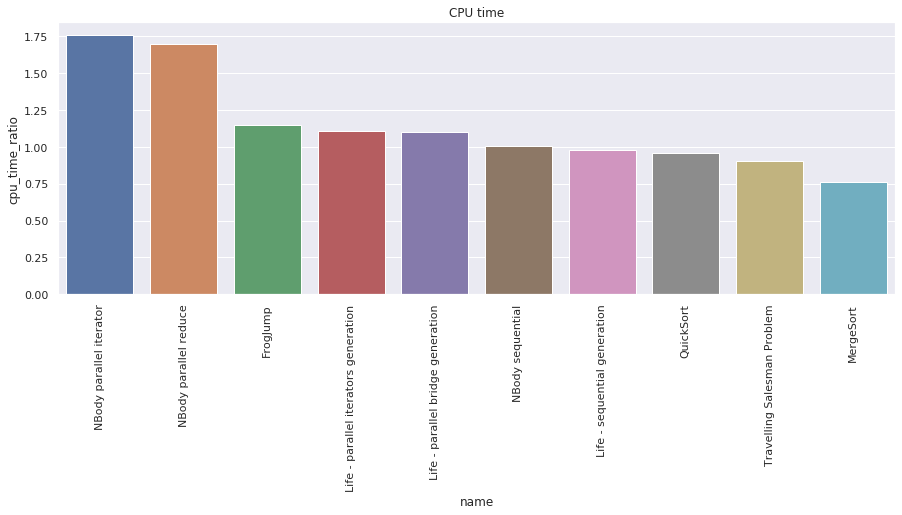

In [6]:
fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.set_title('CPU time')
ax1.set_ylabel('Active time [us]')
ax1.set_xlabel('Algorithm')

sns.barplot(x='name', y='cpu_time_ratio', data=df_to_plot);
plt.xticks(rotation=90);

## Energy

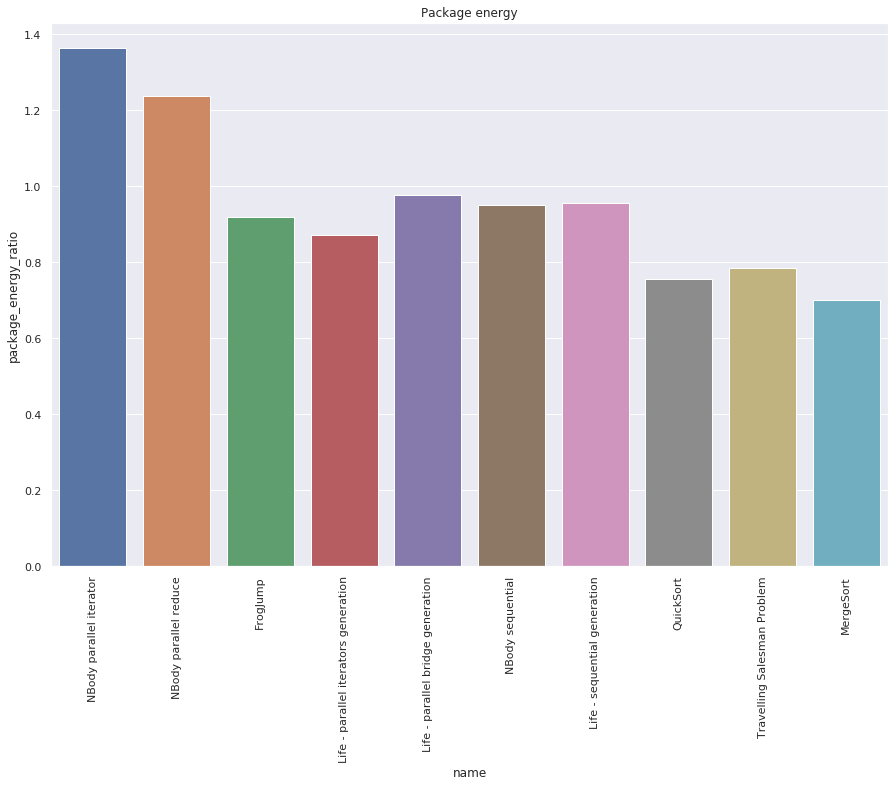

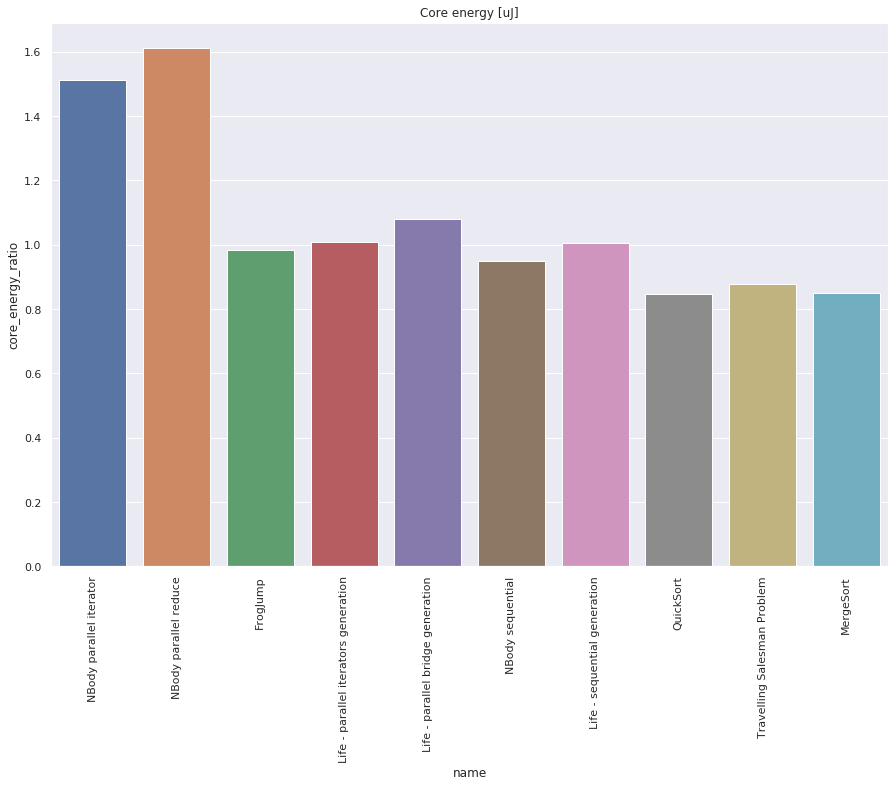

In [7]:
fig2, ax2 = plt.subplots(1, figsize=(15, 10));

ax2.set_title('Package energy')
ax2.set_ylabel('Energy [uJ]')
ax2.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='package_energy_ratio', data=df_to_plot);
plt.xticks(rotation=90);

fig2, ax3 = plt.subplots(1, figsize=(15, 10));

ax3.set_title('Core energy [uJ]')
ax3.set_ylabel('Energy [uJ]')
ax3.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='core_energy_ratio', data=df_to_plot);

plt.xticks(rotation=90);

## Histograms

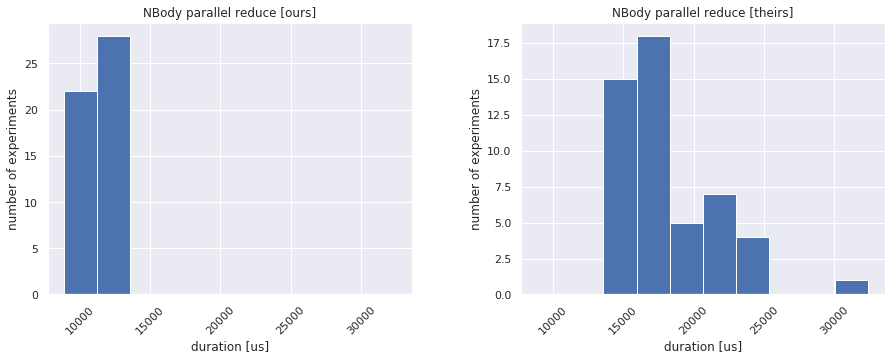

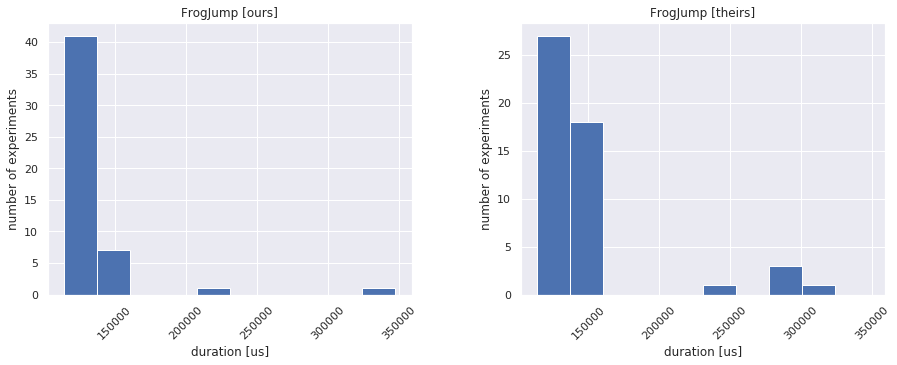

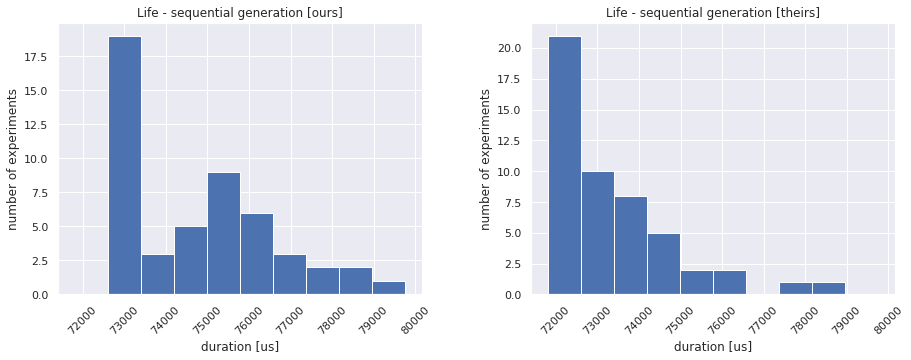

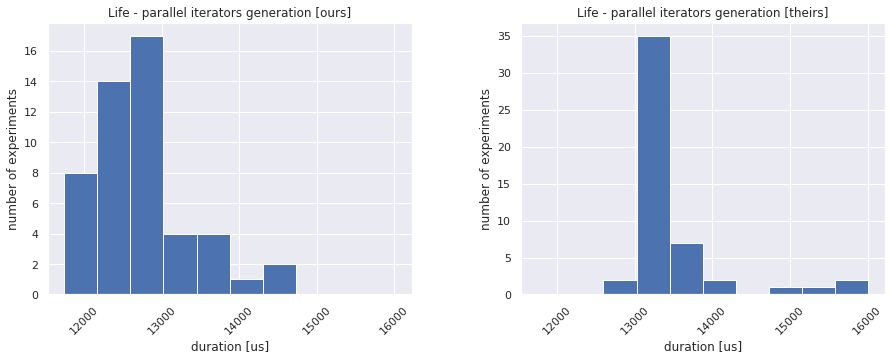

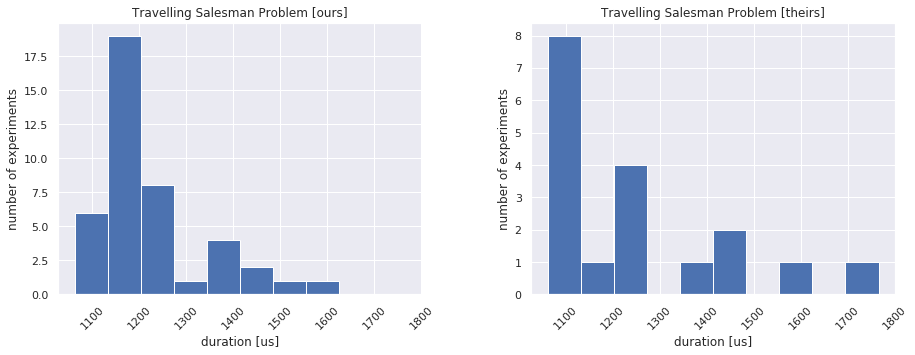

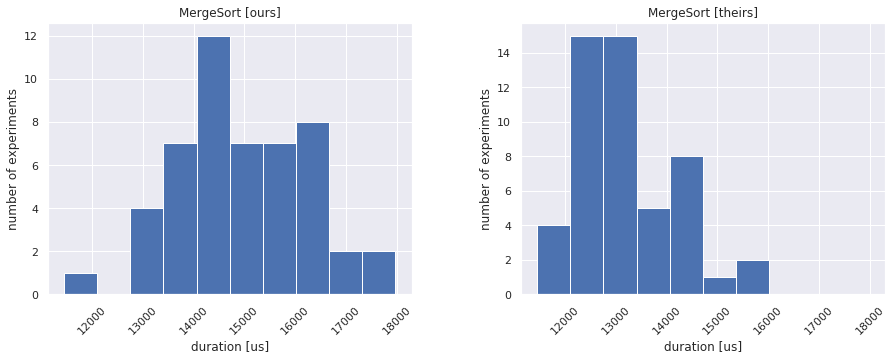

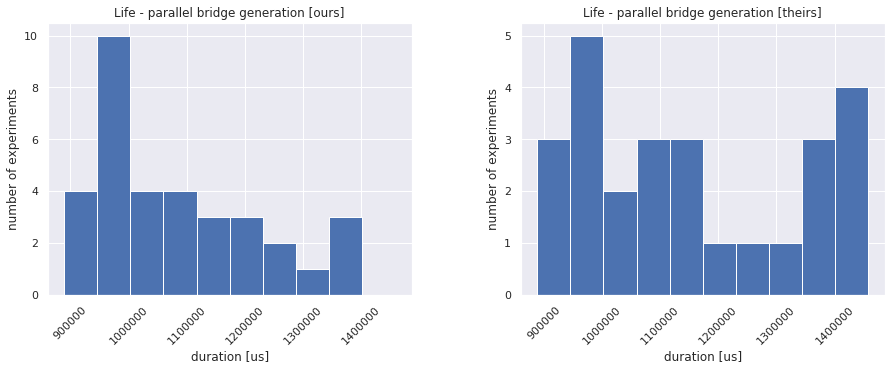

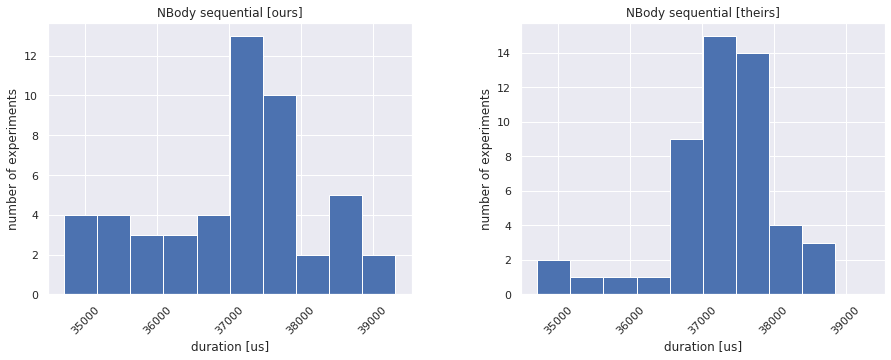

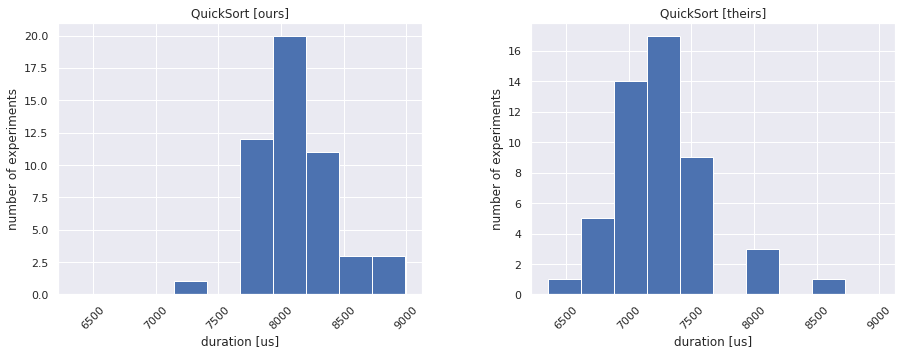

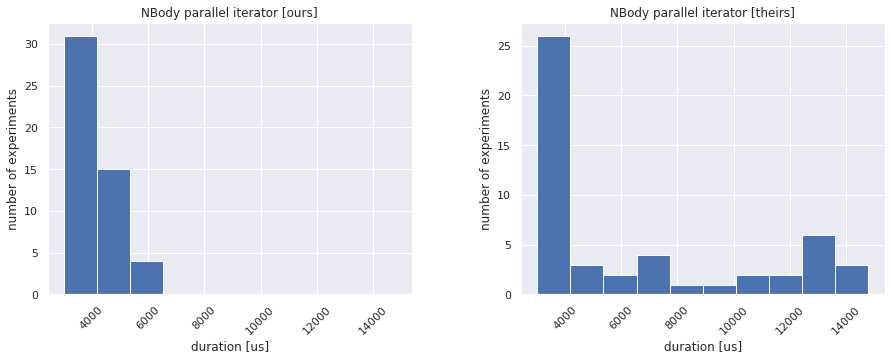

In [8]:
ours = df[df['branch'] != 'master']
theirs = df[df['branch'] == 'master']

for algorithm in set(df['name']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    our_algorithm_df = ours[ours['name'] == algorithm]
    their_algorithm_df = theirs[theirs['name'] == algorithm]
    max_cpu_time = max(our_algorithm_df['wall_clock_time_us'].max(), their_algorithm_df['wall_clock_time_us'].max())
    min_cpu_time = min(our_algorithm_df['wall_clock_time_us'].min(), their_algorithm_df['wall_clock_time_us'].min())
    histogram_range = (min_cpu_time, max_cpu_time)

    our_hist = our_algorithm_df.hist(bins=10, column='wall_clock_time_us', ax=ax1, range=histogram_range)
    ax1.set_title(algorithm + ' [ours]')
    ax1.set_ylabel('number of experiments')
    ax1.set_xlabel('duration [us]')
    ax1.tick_params('x', labelrotation=45)


    their_hist = their_algorithm_df.hist(bins=10, column='wall_clock_time_us', ax=ax2, range=histogram_range)
    ax2.set_title(algorithm + ' [theirs]')
    ax2.set_ylabel('number of experiments')
    ax2.set_xlabel('duration [us]')
    ax2.tick_params('x', labelrotation=45) 
    

# Compare all implementations

## Read data

In [10]:
def experiment_df(folder, branch_name):
    durations = list(range(1, 9, 1)) \
                + list(range(10, 90, 10)) \
#                 + list(range(100, 900, 100)) \
#                 + list(range(1000, 10000, 1000))

    experiment_df = None

    for i in durations:
        filename = folder + '/' + branch_name + '-' + str(i) + '-us.csv'
        our_df = pd.read_csv(filename)
        our_df['branch'] = branch_name
        our_df['sleeping_threshold_us'] = i
        experiment_df = pd.concat([experiment_df, our_df], ignore_index = True)

    return experiment_df

# master_df = pd.read_csv('20-06-2022/jobs-counter-v4/master.csv')
# master_df['branch'] = 'master'
# master_df['sleeping_threshold_us'] = 0


new_algorithm = experiment_df('20-06-2022/limit-threads', 'new-algorithm')
jobs_counter = experiment_df('20-06-2022/jobs-counter', 'jobs-counter')
jobs_counter_v2 = experiment_df('20-06-2022/jobs-counter-v2', 'jobs-counter-v2')
# jobs_counter_v3 = experiment_df('21-06-2022/jobs-counter-v4', 'jobs-counter-v4')

master_df = pd.concat([jobs_counter, jobs_counter_v2], ignore_index = True)

## Plot data

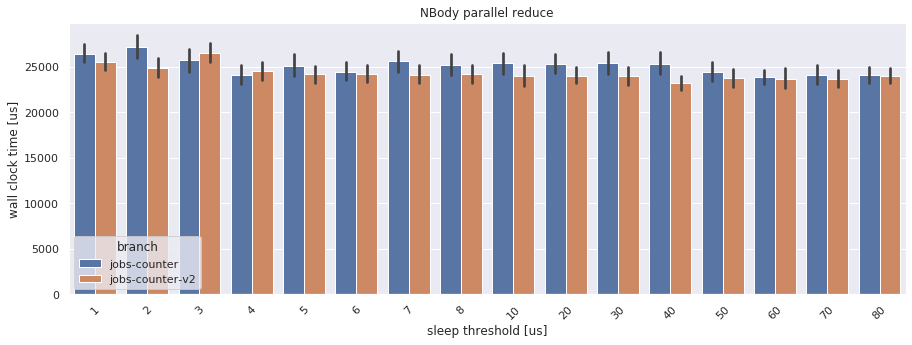

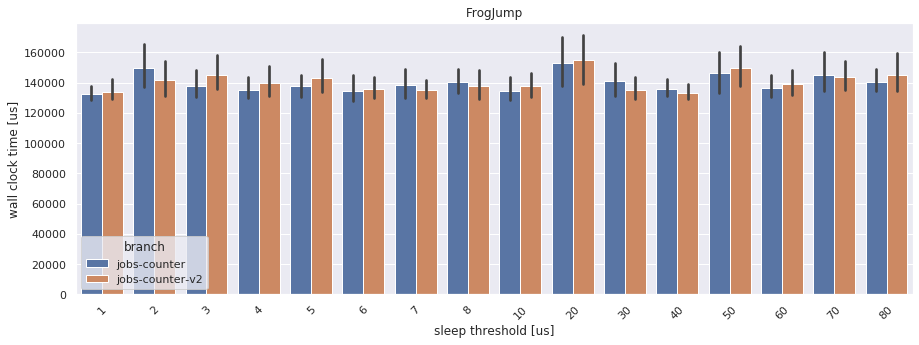

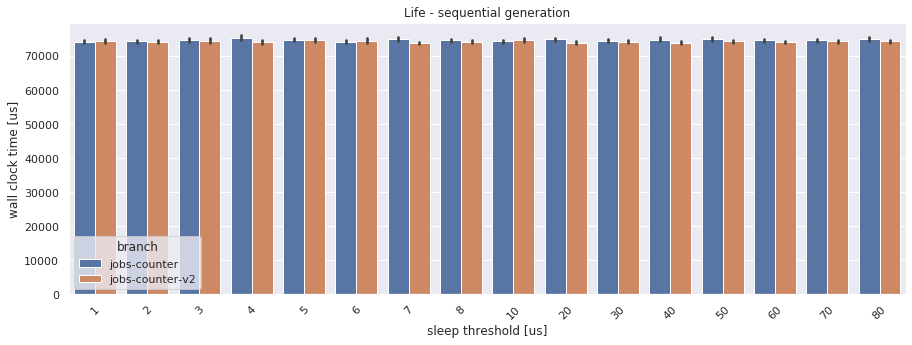

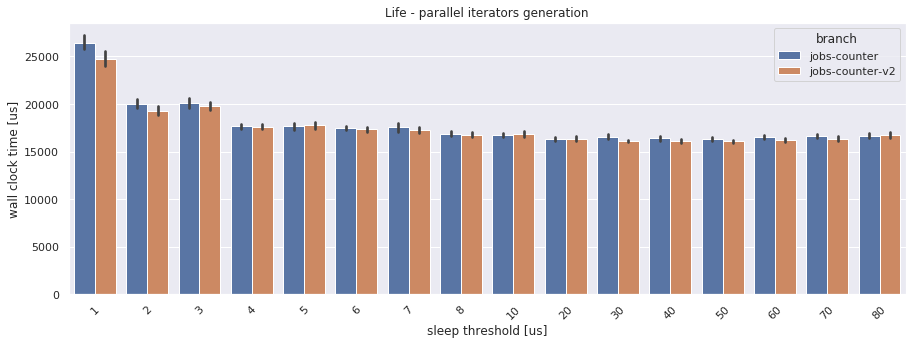

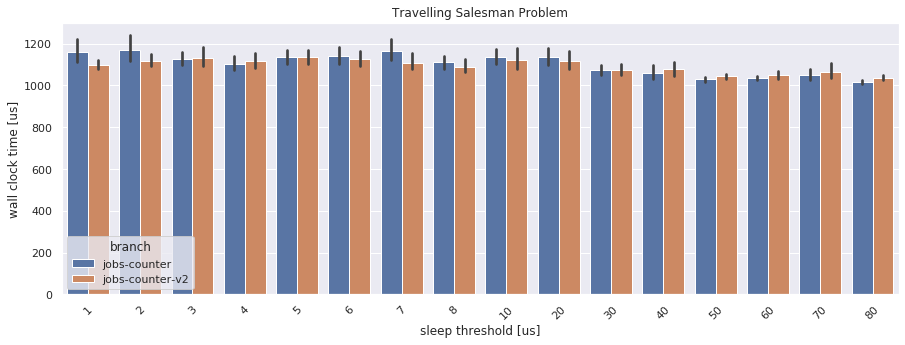

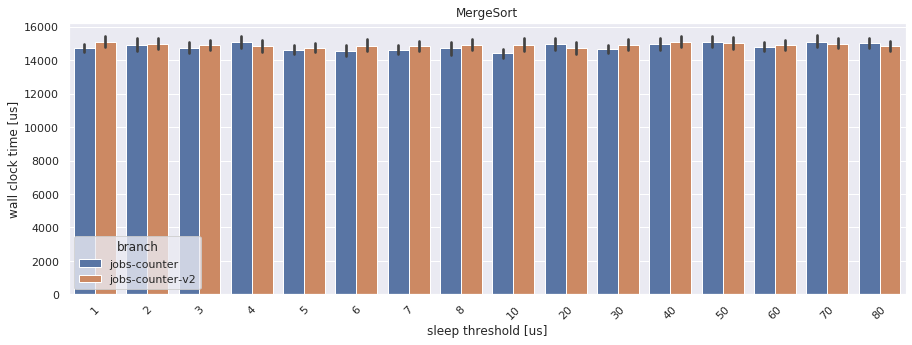

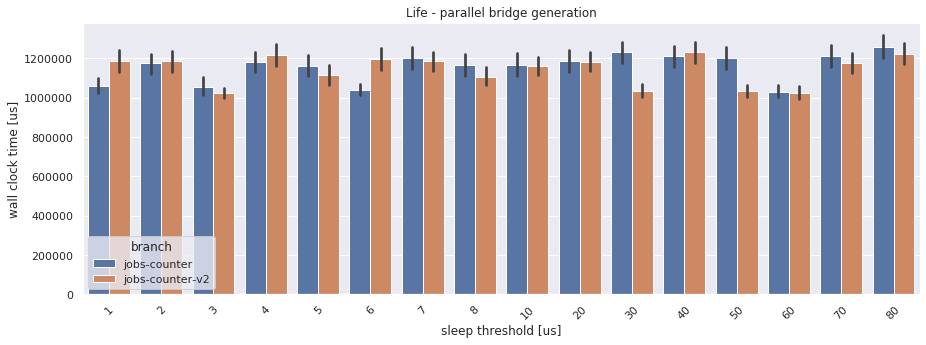

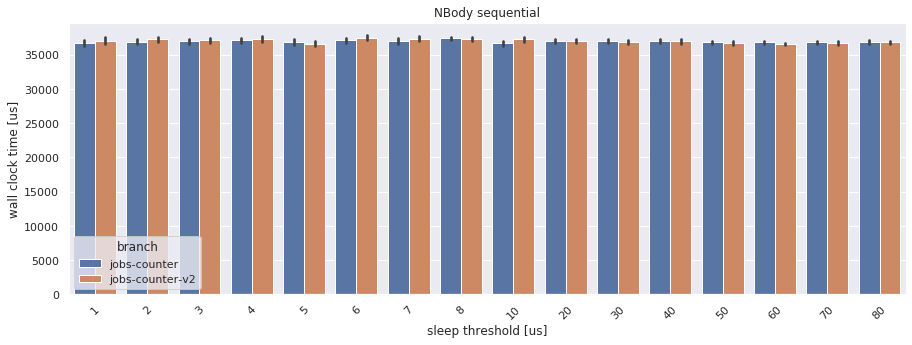

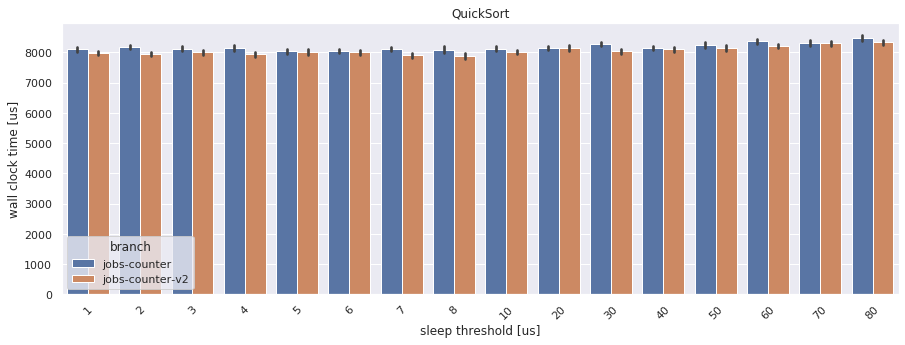

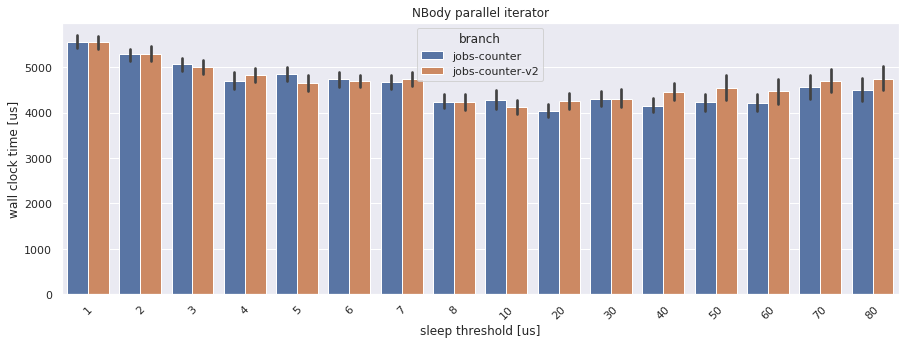

In [11]:
for algorithm in set(master_df['name']):
    df_to_plot = master_df[master_df['name'] == algorithm]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x='sleeping_threshold_us', y='wall_clock_time_us', hue='branch', data=df_to_plot, ax=ax);
    ax.set_title(algorithm)
    ax.set_xlabel('sleep threshold [us]')
    ax.set_ylabel('wall clock time [us]')
    ax.tick_params('x', labelrotation=45) 
    